In [1]:
import geopandas as gpd
import numpy as np
import netCDF4 as nc
from plotting import getIndex, multiVideo, plot2PlusFracNP, plot2PlusFracGeopandas
import matplotlib.pyplot as plt
import shapely.geometry as shg
import matplotlib.pyplot as plt
from IPython.display import HTML
import scipy.linalg as scl
import scipy.ndimage as scn
import scipy.signal as scs
import scipy.fftpack as scf
import scipy.stats as st
import skimage.restoration as sir

In [2]:
data = gpd.read_file('./data/landkreise_fallzahlen.json')
dateColNames = data.columns[6:-1]
n_obs = data[dateColNames]
nrPlaces, nrTimesteps = n_obs.shape

landkreise = data[data.art == 'landkreis']
bundeslaender = data[data.art == 'bundesland']

In [3]:
dataDir = './data/centered'
beforeVals1800mean = np.load(f"{dataDir}/repartitioned_cntr_lastyear_1800.npy")
beforeVals0000mean = np.load(f"{dataDir}/repartitioned_cntr_lastyear_0000.npy")
afterVals1800mean = np.load(f"{dataDir}/repartitioned_cntr_after_1800.npy")
afterVals0000mean = np.load(f"{dataDir}/repartitioned_cntr_after_0000.npy")

(<Figure size 1152x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc3a28bb70>,
       dtype=object))

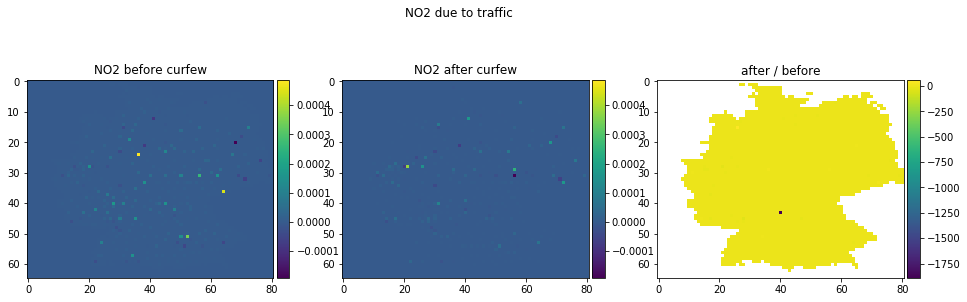

In [4]:
fracNontrafficNight = 0.6
nontraffic = fracNontrafficNight * afterVals0000mean
trafficBefore = beforeVals1800mean - nontraffic
trafficAfter = afterVals1800mean - nontraffic
fraction = trafficAfter / trafficBefore
fraction = np.clip(fraction, 0, 2)

plot2PlusFracNP('NO2 due to traffic', 'NO2 before curfew', 'NO2 after curfew', 'after / before', trafficBefore, trafficAfter)

In [5]:
ncdata = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")

nrLandkreise = len(landkreise.index)
landkreise['no2_1800_before'] = [[] for i in range(nrLandkreise)]
landkreise['no2_1800_after'] = [[] for i in range(nrLandkreise)]
landkreise['no2_0000_before'] = [[] for i in range(nrLandkreise)]
landkreise['no2_0000_after'] = [[] for i in range(nrLandkreise)]

R, C = beforeVals0000mean.shape
N = R*C
for r in range(R):
    for c in range(C):
        print(f"... {100*(r*C+c)/N}% ...")
        lat = ncdata['latitude'][r]
        lon = ncdata['longitude'][c]
        pt = shg.Point(lon, lat)
        for i in landkreise.index:
            lk = landkreise.loc[i]
            if lk.geometry.contains(pt):
                landkreise.loc[i, 'no2_1800_before'] = landkreise.loc[i, 'no2_1800_before'] +  [beforeVals1800mean[r, c]]
                landkreise.loc[i, 'no2_1800_after'] = landkreise.loc[i, 'no2_1800_after'] +  [afterVals1800mean[r, c]]
                landkreise.loc[i, 'no2_0000_before'] = landkreise.loc[i, 'no2_0000_before'] +  [beforeVals0000mean[r, c]]
                landkreise.loc[i, 'no2_0000_after'] = landkreise.loc[i, 'no2_0000_after'] +  [afterVals0000mean[r, c]]
                break


 ...
... 85.84995251661918% ...
... 85.86894586894587% ...
... 85.88793922127256% ...
... 85.90693257359924% ...
... 85.92592592592592% ...
... 85.94491927825261% ...
... 85.9639126305793% ...
... 85.98290598290598% ...
... 86.00189933523266% ...
... 86.02089268755935% ...
... 86.03988603988604% ...
... 86.05887939221273% ...
... 86.0778727445394% ...
... 86.0968660968661% ...
... 86.11585944919278% ...
... 86.13485280151947% ...
... 86.15384615384616% ...
... 86.17283950617283% ...
... 86.19183285849952% ...
... 86.21082621082621% ...
... 86.2298195631529% ...
... 86.24881291547958% ...
... 86.26780626780626% ...
... 86.28679962013295% ...
... 86.30579297245964% ...
... 86.32478632478633% ...
... 86.343779677113% ...
... 86.3627730294397% ...
... 86.38176638176638% ...
... 86.40075973409307% ...
... 86.41975308641975% ...
... 86.43874643874643% ...
... 86.45773979107312% ...
... 86.47673314339981% ...
... 86.4957264957265% ...
... 86.51471984805318% ...
... 86.53371320037986% ...
... 

In [6]:
landkreise['obs_no2_mean_before'] = landkreise['no2_1800_before'].apply(np.mean)
landkreise['obs_no2_mean_after'] = landkreise['no2_1800_after'].apply(np.mean)
landkreise['obs_no2_midnight_mean_before'] = landkreise['no2_0000_before'].apply(np.mean)
landkreise['obs_no2_midnight_mean_after'] = landkreise['no2_0000_after'].apply(np.mean)

In [7]:
# some small LKs have no meassurements of NO2. Copy from their neighbors
for i in range(nrPlaces):
    row0 = landkreise.loc[i]
    if np.isnan(row0['obs_no2_mean_after']):
        for j in range(nrPlaces):
            row1 = landkreise.loc[j]
            if not (np.isnan(row1['obs_no2_mean_after'])) and row1.geometry.touches(row0.geometry):
                landkreise.loc[i, 'obs_no2_mean_after'] = row1['obs_no2_mean_after']
                landkreise.loc[i, 'obs_no2_mean_before'] = row1['obs_no2_mean_before']
                landkreise.loc[i, 'obs_no2_midnight_mean_after'] = row1['obs_no2_midnight_mean_after']
                landkreise.loc[i, 'obs_no2_midnight_mean_before'] = row1['obs_no2_midnight_mean_before']
                break

In [ ]:
landkreise.drop('no2_1800_before', 1, inplace=True)
landkreise.drop('no2_1800_after', 1, inplace=True)
landkreise.drop('no2_0000_before', 1, inplace=True)
landkreise.drop('no2_0000_after', 1, inplace=True)

In [11]:
landkreise.to_file(f"{dataDir}/landkreise_no2_30d.json", driver="GeoJSON", encoding="utf-8")

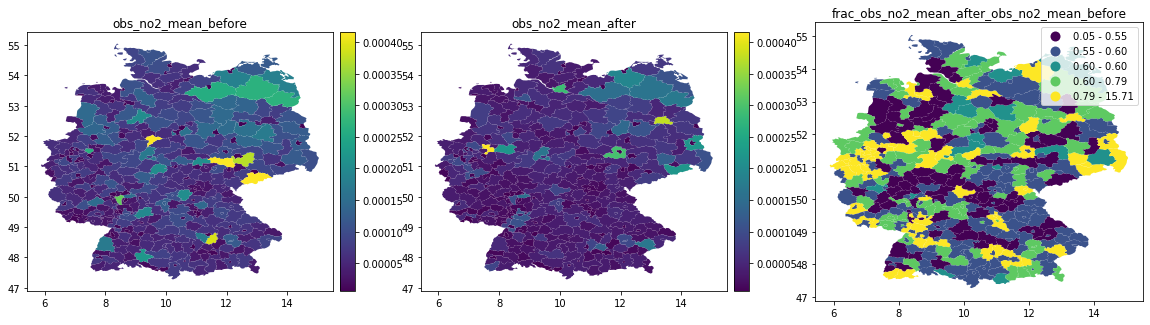

In [9]:
plot2PlusFracGeopandas(landkreise, 'obs_no2_mean_before', 'obs_no2_mean_after')

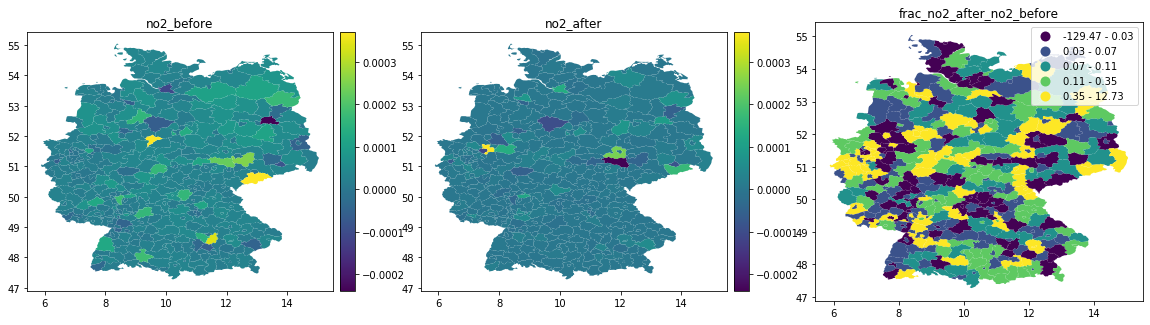

In [10]:
fracNontrafficMidnight = 0.8
nontraffic = fracNontrafficMidnight * landkreise['obs_no2_midnight_mean_after']
landkreise['no2_before'] = landkreise['obs_no2_mean_before'] - nontraffic
landkreise['no2_after'] = landkreise['obs_no2_mean_after'] - nontraffic
plot2PlusFracGeopandas(landkreise, 'no2_before', 'no2_after')